In [1]:
from IPython.display import display, clear_output
from bin.config import *
from bin.consumer import Consumer

In [2]:
spark_session: SparkSession = (
    SparkSession.builder.appName("Real-time Evaluation Prediction")
    .config("spark.jars.packages", ",".join(SPARK_PACKAGES))
    .getOrCreate()
)

In [3]:
capture_con: Consumer = Consumer(
    CAPTURE_TOPIC, CAPTURE_SCHEMA_LIST, spark_session
)

prediction_con: Consumer = Consumer(
    PREDICTION_TOPIC, PREDICTION_SCHEMA_LIST, spark_session
)

In [4]:
capture_df: DataFrame = capture_con.get_history_df()
prediction_df: DataFrame = prediction_con.get_history_df()

prediction_df = (
    prediction_df.withColumn("range_history", F.col("max_history_ds") - F.col("min_history_ds"))
    .withColumn("future_forecasting", F.col("Timestamp") - F.col("max_history_ds"))
)

In [5]:
join_df = (
    capture_df.join(
        prediction_df,
        on=["SegmentID", "Timestamp", "Direction"],
        how="inner"
    )
    .withColumns({
        "AE": F.abs(F.col("Vol") - F.col("prediction_vol")),
        "APE": F.col("AE") / F.col("Vol"),
        "range_days": F.expr("cast(range_history as int) / 60 / 60 / 24"),
        "future_forecasting_minutes": F.expr("cast(future_forecasting as int) / 60"),
    }).drop("prediction_ds").distinct()
)

In [8]:
result_df = (
    join_df
    .filter(F.col("range_days").isin(1, 3, 7))
    .groupBy("range_days", "future_forecasting_minutes")
    .agg(
        F.mean("AE").alias("MAE"),
        F.mean("APE").alias("MAPE"),
    ).orderBy("range_days", "future_forecasting_minutes")
)

In [9]:
try:
    while True:
        display(result_df.show(75, truncate=False))
        sleep(DELAY)
        clear_output(wait=False)
except KeyboardInterrupt:
    print("Stopping live...")

+----------+--------------------------+------------------+------------------+
|range_days|future_forecasting_minutes|MAE               |MAPE              |
+----------+--------------------------+------------------+------------------+
|1.0       |15.0                      |64.13970947428265 |2.87066304247903  |
|1.0       |30.0                      |67.92340430977764 |2.9050849784161774|
|1.0       |45.0                      |70.32642432474415 |2.9639764473463264|
|1.0       |60.0                      |73.09146498073481 |2.898166966788776 |
|3.0       |15.0                      |38.581803130544074|1.5442228759566115|
|3.0       |30.0                      |40.09459047903499 |1.7126250256988327|
|3.0       |45.0                      |40.94652175544726 |1.6619707334253035|
|3.0       |60.0                      |42.8342712686044  |2.1782023838055298|
|7.0       |15.0                      |39.3667893979937  |1.424235342899521 |
|7.0       |30.0                      |40.09581163500092 |1.4618

None

Stopping live...


In [10]:
result_pdf = result_df.toPandas()

In [11]:
result_pdf

,range_days,future_forecasting_minutes,MAE,MAPE
0,1.0,15.0,64.139709,2.870663
1,1.0,30.0,67.923404,2.905085
2,1.0,45.0,70.326424,2.963976
3,1.0,60.0,73.091465,2.898167
4,3.0,15.0,38.581803,1.544223
5,3.0,30.0,40.094590,1.712625
6,3.0,45.0,40.946522,1.661971
7,3.0,60.0,42.834271,2.178202
8,7.0,15.0,39.366789,1.424235
9,7.0,30.0,40.095812,1.461807


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
plt.rcParams['font.family'] = 'Bahnschrift'  # Change 'your_font_family' to the desired font family


result_pdf["future_forecasting_minutes"] = result_pdf["future_forecasting_minutes"].astype('int')
result_pdf["range_days"] = result_pdf["range_days"].astype('int')

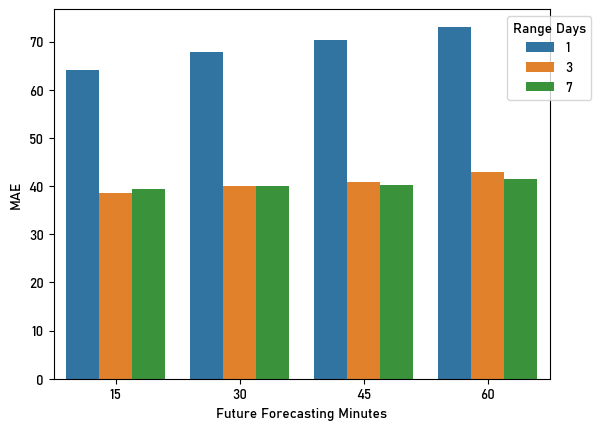

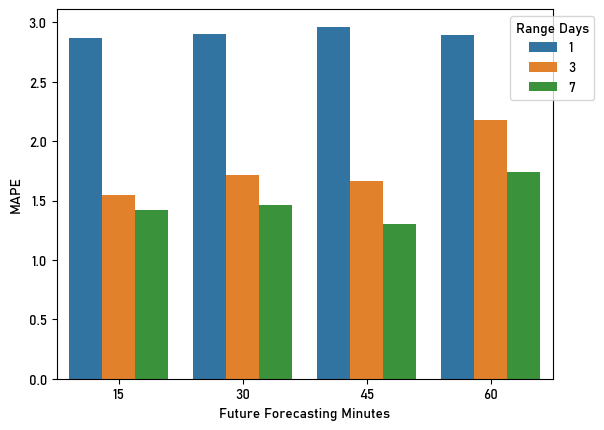

In [14]:
sns.barplot(data=result_pdf, x="future_forecasting_minutes", y="MAE", hue="range_days")
plt.legend(title="Range Days", bbox_to_anchor=(0.9, 1), loc='upper left')
plt.xlabel("Future Forecasting Minutes")
plt.show()

sns.barplot(data=result_pdf, x="future_forecasting_minutes", y="MAPE", hue="range_days")
plt.legend(title="Range Days", bbox_to_anchor=(0.9, 1), loc='upper left')
plt.xlabel("Future Forecasting Minutes")
plt.show()

